# Classify Iris

## Import Libraries

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from typing import Tuple

## Preparing datasets of iris

In [10]:
iris = datasets.load_iris()

## Standardizing input data

In [11]:
def standardized(data: np.ndarray) -> np.ndarray:
    avg = np.average(data)
    std = np.std(data, axis=0)
    return (data - avg) / std


input_data = standardized(iris.data)

## Converting target data to one-hot format

In [12]:
def to_onehot_format(data: np.ndarray) -> np.ndarray:
    size = len(data)
    formatted = np.zeros((size, 3))
    for i in range(size):
        formatted[i, data[i]] = 1.0
    return formatted

target_data = to_onehot_format(iris.target)

## Divide dataset into train and test

In [13]:
input_train = input_data[0::2]
input_test  = input_data[1::2]
target_train = target_data[0::2]
target_test = target_data[1::2]

## Implementing Neural Network

In [14]:
class BaseLayer:
    def __init__(self, n_x: int, n_y: int, w_max = 0.1, b_max = 0.1) -> None:
        self.w = np.random.randn(n_x, n_y) * w_max
        self.b = np.random.randn(n_y) * b_max

    def update(self, eta: float) -> None:
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

class MiddleLayer(BaseLayer):
    # Adopt ReLU function as activation function
    def forward(self, x: np.ndarray) -> None:
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u)

    def backward(self, grad_y: np.ndarray) -> None:
        delta = grad_y * np.where(self.u <= 0, 0, 1)
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)

class OutputLayer(BaseLayer):
    def forward(self, x: np.ndarray):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = np.exp(u) / np.sum(np.exp(u), axis=1, keepdims=True)

    def backward(self, t: np.ndarray):
        delta = self.y - t
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)

class NeuralNetwork:
    def __init__(self, n_i: int, n_m: int, n_o: int) -> None:
        self.middle_layer1 = MiddleLayer(n_i, n_m)
        self.middle_layer2 = MiddleLayer(n_m, n_m)
        self.output_layer  = OutputLayer(n_m, n_o)

    def forward(self, x: np.ndarray):
        self.middle_layer1.forward(x)
        self.middle_layer2.forward(self.middle_layer1.y)
        self.output_layer.forward(self.middle_layer2.y)
    
    def backward(self, t: np.ndarray):
        self.output_layer.backward(t)
        self.middle_layer2.backward(self.output_layer.grad_x)
        self.middle_layer1.backward(self.middle_layer2.grad_x)

    def update(self, eta: float) -> None:
        self.middle_layer1.update(eta)
        self.middle_layer2.update(eta)
        self.output_layer.update(eta)

    def get_error(self, t: np.ndarray, batch_size: int):
        return -np.sum(t * np.log(self.output_layer.y + 1e-7)) / batch_size

## Plotting Leaning Process with Mini-Badge Method

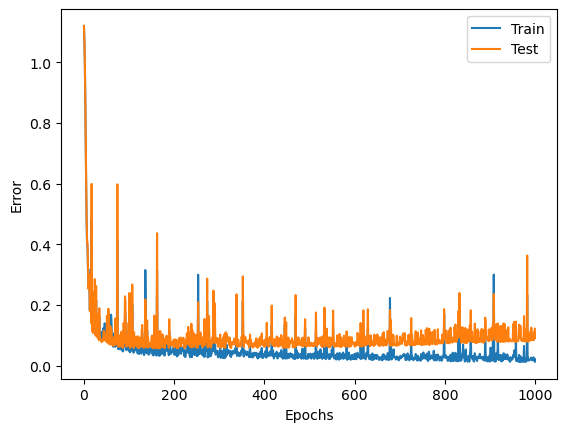

In [16]:
eta = 0.01
epoch = 1000
batch_size = 8
interval = 100

nn = NeuralNetwork(
    n_i=4,
    n_m=25,
    n_o=3
)

train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

n_batch = len(input_train) // batch_size
for i in range(epoch):
    nn.forward(input_train)
    train_error_x.append(i)
    train_error_y.append(nn.get_error(target_train, len(input_train)))
    nn.forward(input_test)
    test_error_x.append(i)
    test_error_y.append(nn.get_error(target_test, len(input_test)))

    index_random = np.arange(len(input_train))
    np.random.shuffle(index_random)
    for j in range(n_batch):
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x = input_train[mb_index, :]
        t = target_train[mb_index, :]
        nn.forward(x)
        nn.backward(t)
        nn.update(eta)

nn.forward(input_train)
train_error_x.append(i)
train_error_y.append(nn.get_error(target_train, len(input_train)))
nn.forward(input_test)
test_error_x.append(i)
test_error_y.append(nn.get_error(target_test, len(input_test)))

plt.plot(train_error_x, train_error_y, label="Train")
plt.plot(test_error_x, test_error_y, label="Test")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.show()